In [1]:
import copy
import math
import random

%matplotlib inline
import mpld3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
mpld3.enable_notebook()

import numpy as np
from numpy import linalg as LA

from colorsys import hsv_to_rgb
from PIL import Image

In [2]:
class incrementalOffPolicy(object):
    def __init__(self, filename):
        actualMap = np.array(self.txt_to_obs_map('track1.txt'))
        reviseMap = np.empty(actualMap.shape)
        for i in range(0,len(actualMap)):
            reviseMap[i,] = actualMap[len(actualMap)-1-i,]
        self.map = copy.copy(np.transpose(reviseMap))
        
        self.start = np.empty([1,2],dtype=int)
        for i in range(0, self.map.shape[0]):
            if self.map[i,0] == 0:
                self.start = np.vstack((self.start,(i,0)))
        self.start = np.delete(self.start,(0), axis=0)
        
        self.finish = np.empty([1,2])
        for i in range(0, self.map.shape[1]):
            if self.map[self.map.shape[0]-1,i] == 0:
                self.finish = np.vstack((self.finish,(self.map.shape[0]-1,i)))
        self.finish = np.delete(self.finish, (0), axis=0)
        
        self.epsilon = 1
        self.initialVelocity = [0,0]
        self.allActions = np.array(((-1,-1), (-1,0), (-1,1), 
                                        (0,-1), (0,0), (0,1),
                                        (1,-1), (1,0), (1,1)))
        self.maxVelocity = 5
        self.minVelocity = 0
        self.numStates = self.map.size*(self.maxVelocity - self.minVelocity + 1)**2
        self.numActions = len(self.allActions)
        try:
            self.Q = np.random.rand(self.numStates,self.numActions)
#             self.Q = np.loadtxt('newq_2050000.txt')
        except:
            self.Q = np.empty(shape=(self.numStates,self.numActions))

        self.C = np.zeros(shape=(self.numStates,self.numActions))
        self.finishState = np.empty(shape=(1,4))

    def txt_to_obs_map(self, file_name):
        with open(file_name) as inputFile:
            return [[int(i) for i in line.strip().split('\t')] for line in inputFile]

    def behaviourPolicy(self):
        return np.random.randint(9)

    def targetPolicy1(self, previousState):
        if(previousState[1] ==0):
            xVel = 0
            yVel = 1
        elif (previousState[1] < 28):
            if(previousState[3] == 0):
                xVel = 0
                yVel = 1
            else:
                xVel = 0
                yVel = 0
        elif(previousState[1] >= 28):
            xVel = 1
            if(previousState[3] == 0):
                yVel = 0
            else:
                yVel = -1
        return np.array((xVel, yVel))
    
    def uniformTargetPolicy(self):
        policy = np.zeros(self.Q.shape)
        for i in range(0, self.Q.shape[0]):
            state = self.statesIndex2states(i)
            possibleActions = self.possibleActions(state[2], state[3])
            numPossibleActions = np.sum(possibleActions)
            policy[i] = 1.0*possibleActions/numPossibleActions
#         policy = np.random.uniform(0,1,(self.map.size*6*6,9))
#         for i in range(0, policy.shape[0]):
#             policy[i] = policy[i]/LA.norm(policy[i])
        return policy
    
    def greedyTargetPolicy(self, policy, episode):
        for i in range(0, episode.shape[0]):
            stateIndex = self.stateIndex(episode[i])
            state = copy.copy(self.statesIndex2states(stateIndex))
            possibleActions = self.possibleActions(state[2], state[3])
            numPossibleActions = np.sum(possibleActions)
            possibleActionsBool = possibleActions == 1
            maxQ = np.amax(self.Q[stateIndex, possibleActionsBool])
            for j in range(0,len(possibleActions)):
                if possibleActions[j] == 1:
                    if self.Q[stateIndex,j] == maxQ:
                        policy[stateIndex,j] = 1 - self.epsilon + self.epsilon/numPossibleActions
                    else:
                        policy[stateIndex,j] = self.epsilon/numPossibleActions
        return policy
    
    def updateTargetPolicy(self, policy, state):
        stateIndex = self.stateIndex(state)
        possibleActions = self.possibleActions(state[2], state[3])
        numPossibleActions = np.sum(possibleActions)
        if numPossibleActions==0:
            print("error: ", possibleActions)
        possibleActionsBool = possibleActions == 1
        maxQ = np.amax(self.Q[stateIndex, possibleActionsBool])
        greedyActions = self.Q[stateIndex,possibleActionsBool] == maxQ
        numGreedyActions = sum(greedyActions)
        for j in range(0,len(possibleActions)):
            policy[stateIndex,j] = 0
            if possibleActions[j] == 1:
                if self.Q[stateIndex,j] == maxQ:
                    policy[stateIndex,j] = (1.0 - self.epsilon)/numGreedyActions + self.epsilon/numPossibleActions
                else:
                    policy[stateIndex,j] = self.epsilon/numPossibleActions
        if np.sum(policy[stateIndex]) > 1.001 or np.sum(policy[stateIndex]) < 0.998:
            print(possibleActions)
            print(self.Q[stateIndex])
            print(possibleActionsBool,maxQ)
            print("state: ", state)
            print("policy: ", policy[stateIndex])
            print("gredyActions: ",greedyActions)
        return policy
    
    def possibleActions(self, velocity_x, velocity_y):
        possibleActions = np.ones(self.numActions)
#         print(possibleActions)
        for j in range(0, self.numActions):
            projVelocityX = velocity_x + self.allActions[j,0]
            projVelocityY = velocity_y + self.allActions[j,1]
            # print(projVelocityX, projVelocityY, self.allActions[j])
            if (projVelocityX>=self.minVelocity and projVelocityX<=self.maxVelocity and 
                projVelocityY>=self.minVelocity and projVelocityY<=self.maxVelocity):
                if projVelocityX==self.minVelocity and projVelocityY==self.minVelocity:
                    possibleActions[j] = 0
                else:
                    possibleActions[j] = 1
            else:
                possibleActions[j] = 0
#         print(possibleActions)
        return possibleActions

    def generateEpisode(self, policy):
        # print(self.start, self.start.shape)
        previousState = np.append(self.start[np.random.randint(self.start.shape[0])], [0,0])
        episode = np.zeros(shape=(1,6))
        while True:
            stateIndex = self.stateIndex(previousState)
            temp = copy.copy(policy[stateIndex])
#             print(stateIndex, temp, np.sum(temp))
            actionIndex = np.random.choice(9,1, p=temp.tolist())
            action = copy.copy(self.allActions[actionIndex])
            velocity_x = max(min((previousState[2]+action[0,0]),5),0)
            velocity_y = max(min((previousState[3]+action[0,1]),5),0)
            nextState = np.array(((previousState[0] + velocity_x),
                                    (previousState[1] + velocity_y), velocity_x, velocity_y))
            nextState = nextState.astype(int)
            intersection = self.projectedIntersection(previousState, nextState)
            if (intersection == 2):
                nextState = np.append(copy.copy(
                    self.start[np.random.randint(self.start.shape[0])]), [0,0])
#                 self.finishState[0,2] = copy.copy(velocity_x)
#                 self.finishState[0,3] = copy.copy(velocity_y)
                reward = -1
#                 break
            elif (intersection == 1):
                # episode = np.vstack((episode, np.append(nextState,np.array((0, action[0], action[1])))))
                self.finishState[0,2] = copy.copy(velocity_x)
                self.finishState[0,3] = copy.copy(velocity_y)
                break
            else:
                reward = -1
                
#             print(np.append(previousState,[reward, actionIndex]), episode.shape, stateIndex)

            if episode.shape[0] == 1:
                episode = np.append(previousState, [reward, actionIndex])
            else:
                episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
            previousState = copy.copy(nextState)
            
#         print(np.append(previousState, [reward, actionIndex]), episode.shape)
        episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
#         print(np.append(previousState,np.array((reward, actionIndex))))
        episode =np.vstack((episode, np.append(self.finishState, [reward, actionIndex])))
        return episode

    def projectedIntersection(self, previousState, nextState):
        projectedState = copy.copy(previousState[0:2])
#         print(projectedState)
        for i in range(0, max(nextState[2], nextState[3])+1):
            if(np.amin(np.sum(np.absolute(self.finish - np.array(projectedState[0:2])),axis=1)) ==0):
                self.finishState[0,0] = copy.copy(projectedState[0])
                self.finishState[0,1] = copy.copy(projectedState[1])
                return 1
            if(projectedState[0] >= self.map.shape[0]-1 or projectedState[1] >= self.map.shape[1]-1 or 
               self.map[projectedState[0],projectedState[1]] == 1):
                self.finishState[0,0] = copy.copy(projectedState[0])
                self.finishState[0,1] = copy.copy(projectedState[1])
                return 2
#             elif(self.map[projectedState[0],projectedState[1]] == 1):
#                 return 2
            projectedState[0] = min(projectedState[0]+1,nextState[0])
            projectedState[1] = min(projectedState[1]+1,nextState[1])
        return 3
    
    def stateIndex(self, currentState):
        velRange = (self.maxVelocity - self.minVelocity + 1)
        return int((velRange**2)*(currentState[1]*self.map.shape[0] + currentState[0]) + 6*currentState[3] + currentState[2] )
    
    def statesIndex2states(self, stateIndex):
        velRange = (mc.maxVelocity - mc.minVelocity + 1)
        velocity_x = (stateIndex%(velRange**2))%velRange
        velocity_y = (stateIndex%(velRange**2))/velRange
        stateY = int(int(stateIndex/velRange**2)/mc.map.shape[0])
        stateX = int(int(stateIndex/velRange**2)%mc.map.shape[0])
        return np.array((stateX, stateY, velocity_x, velocity_y))

In [3]:
mc = incrementalOffPolicy(filename = 'track1.txt')

In [4]:
gamma = 1.
count = 0
policyPI = mc.uniformTargetPolicy()

In [33]:
otherCount = 0
while count <= 100000:
    episode = mc.generateEpisode(policyPI)
    # state : {x, y, vx, vy}
    # action-value function q(every state): vector of 36*9 elements for every grid
    G = 0.
#         W = 1.
    otherCount = 0
    for i in range(episode.shape[0]-2, -1, -1):
        state = copy.copy(episode[i])
        G = gamma*G + episode[i,4]
        ind1 = mc.stateIndex(episode[i])
        ind2 =  int(copy.copy(episode[i,5]))
        mc.C[ind1,ind2] += 1
        mc.Q[ind1,ind2] = mc.Q[ind1,ind2] + (1./mc.C[ind1,ind2])*(G - mc.Q[ind1,ind2])
#             W = W*policyPI[ind1,ind2]*np.sum(mc.possibleActions(state[2], state[3]))/np.sum(policyPI[ind1])
        policyPI = mc.updateTargetPolicy(policyPI, state)
        otherCount += 1
#             print("cnt:", count, "otherC:", otherCount,"  state:", state)
    count += 1
#     if (count%500 ==0 and mc.epsilon >0.1):
#         mc.epsilon -= 0.05
    if (count%100 == 0):
        print("cnt:", count, "otherC:", otherCount,"  state:", state)
#     if (count % 1000 == 0):
#         np.savetxt('oldq_%d.txt'% count, mc.Q, fmt='%.18e', delimiter=' ', newline='\n')

np.savetxt('oldQ.txt', mc.Q, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt('oldN.txt', mc.C, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt('oldPolicy.txt', policyPI, fmt='%.18e', delimiter=' ', newline='\n')

cnt: 76700 otherC: 885   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 76800 otherC: 173   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 76900 otherC: 106   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 77000 otherC: 430   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 77100 otherC: 524   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 77200 otherC: 210   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 77300 otherC: 380   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 77400 otherC: 86   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 77500 otherC: 15   state: [ 3.  0.  0.  0. -1.  5.]
cnt: 77600 otherC: 390   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 77700 otherC: 398   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 77800 otherC: 740   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 77900 otherC: 94   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 78000 otherC: 178   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 78100 otherC: 299   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 78200 otherC: 1322   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 78300 otherC: 132   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 78400 other

cnt: 90900 otherC: 598   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 91000 otherC: 50   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 91100 otherC: 206   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 91200 otherC: 412   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 91300 otherC: 30   state: [ 6.  0.  0.  0. -1.  8.]
cnt: 91400 otherC: 57   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 91500 otherC: 25   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 91600 otherC: 217   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 91700 otherC: 620   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 91800 otherC: 26   state: [ 7.  0.  0.  0. -1.  8.]
cnt: 91900 otherC: 217   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 92000 otherC: 157   state: [ 5.  0.  0.  0. -1.  8.]
cnt: 92100 otherC: 379   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 92200 otherC: 283   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 92300 otherC: 147   state: [ 4.  0.  0.  0. -1.  8.]
cnt: 92400 otherC: 681   state: [ 3.  0.  0.  0. -1.  8.]
cnt: 92500 otherC: 110   state: [ 8.  0.  0.  0. -1.  8.]
cnt: 92600 otherC: 

In [34]:
mc.epsilon

0.05

In [35]:
# hsv values for plotting 10 paths
HSV_VALS = [[0.5574, 0.2687, 0.8902],
            [0.6667, 1.0000, 1.0000],
            [0.3333, 1.0000, 1.0000],
            [0.1667, 1.0000, 1.0000],
            [0.0017, 0.3904, 0.9843],
            [0.0939, 0.5613, 0.9922],
            [0.0830, 1.0000, 1.0000],
            [0.7778, 0.1682, 0.8392],
            [0.7473, 0.6039, 0.6039],
            [0.0596, 0.7740, 0.6941]]

# offset so colors aren't too light
OFFSET = 25

def colorize_path(track, path, save_location):
    newTrack = np.zeros
    path_map = np.uint8((np.array(track) == 0) * 255)
    (h,w) = path_map.shape
    path_map = np.repeat(path_map,3).reshape((h,w,3))

    for i in range(0,path.shape[0]):
        (x, y) = path[i]
#         print(x,y)
        path_map[int(x),int(y)] = [int(a * 255) for a in hsv_to_rgb(HSV_VALS[0][0],float(i+OFFSET)/(path.shape[0]+OFFSET) * HSV_VALS[0][1],HSV_VALS[0][2])]
#         comp_path = [path_elem for path_elem in path[i] if path_elem is not None]
#         duplicates = set([a for a in comp_path if comp_path.count(a) > 1])
#         if len(duplicates) > 0:
#             for (r,c) in duplicates:
#                 path_map[r,c] = [255,0,0] # red color for collisions
#                 print("collision at:", (r,c))
    im = Image.fromarray(path_map, 'RGB')
    im.save(save_location)

[12 25  3  1 -1  6] (865, 6)
[12 25  3  1 -1  6]
steps:  867 totalReard:  -867.0


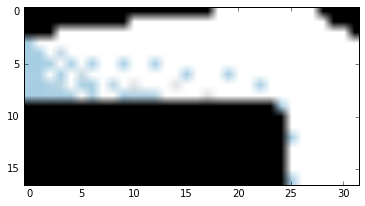

In [37]:
mc = incrementalOffPolicy(filename = 'track1.txt')
mc.Q = np.loadtxt('oldQ.txt')
policyPI = np.loadtxt('oldPolicy.txt')
previousState = np.append(mc.start[np.random.randint(mc.start.shape[0])], [0,0])
# previousState = np.append(mc.start[2],(0, 0))
stateInd = 1
episode = np.zeros(shape=(1,7))
while True:
    stateIndex = mc.stateIndex(previousState)
    temp = copy.copy(policyPI[stateIndex])
#             print(stateIndex, temp, np.sum(temp))
    actionIndex = np.random.choice(9,1, p=temp.tolist())[0]
#     actionIndex = np.argmax(mc.Q[stateIndex])
    action = copy.copy(mc.allActions[actionIndex])
#     print(action)
    velocity_x = max(min((previousState[2]+action[0]),5),0)
    velocity_y = max(min((previousState[3]+action[1]),5),0)
    nextState = np.array(((previousState[0] + velocity_x),
                            (previousState[1] + velocity_y), velocity_x, velocity_y))
    nextState = nextState.astype(int)
    intersection = mc.projectedIntersection(previousState, nextState)
    if (intersection == 2):
        nextState = np.append(copy.copy(
                        mc.start[np.random.randint(mc.start.shape[0])]), [0,0])
#         mc.finishState[0,2] = copy.copy(velocity_x)
#         mc.finishState[0,3] = copy.copy(velocity_y)
        reward = -1
#         break
    elif (intersection == 1):
        # episode = np.vstack((episode, np.append(nextState,np.array((0, action[0], action[1])))))
        mc.finishState[0,2] = copy.copy(velocity_x)
        mc.finishState[0,3] = copy.copy(velocity_y)
        break
    else:
        reward = -1

#     print(np.append(previousState,[reward, actionIndex]), episode.shape, stateIndex)

    if episode.shape[0] == 1:
        episode = np.append(previousState, [reward, actionIndex])
    else:
        episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
    previousState = copy.copy(nextState)
            
print(np.append(previousState, [reward, actionIndex]), episode.shape)
episode = np.vstack((episode, np.append(previousState, [reward, actionIndex])))
print(np.append(previousState,np.array((reward, actionIndex))))
episode =np.vstack((episode, np.append(mc.finishState, [reward, actionIndex])))
path = copy.copy(episode[:,0:2])
print("steps: ", path.shape[0], "totalReard: ", sum(episode[:,4]))
colorize_path(mc.map, path, "path.png")
# IM(filename='path.png')
img=mpimg.imread('path.png')
plt.imshow(img)